In [2]:
from __future__ import print_function, division
import mdtraj as md
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import scipy 
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools 
import pickle
import pandas as pd
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from scipy.stats import pearsonr

from deeptime.clustering import KMeans
from deeptime.data import double_well_2d
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales 
from deeptime.plots.chapman_kolmogorov import plot_ck_test
import pyemma.coordinates
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pyinform

import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import deeptime
from deeptime.decomposition import TICA
import pyemma
from deeptime.clustering import KMeans

In [3]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 3.0

In [9]:
def fes2d(x,y,ax = None, xlabel = None,ylabel = None, cmap= 'jet',
           cbar = True, bins=250, weights=None, vmin=None,vmax=None,
           scatterx = None, scattery = None):
        z,x,y = np.histogram2d(x,y,bins=bins,weights=weights)
        extent = (x.min(), x.max(), y.min(), y.max())
        arr = np.ma.masked_array(z,z==0)
        F=-np.log(arr)
        F+=-F.min()
        if ax is None:
            fig,ax=plt.subplots(1,1,sharex=True,sharey=True)
        if not ((scatterx is None) or (scattery is None)):
            ax.scatter(scatterx, scattery, c='grey', s=60, edgecolors='black', alpha=0.5)
        a=ax.contourf(F.T,300,cmap=cmap,extent=extent,zorder=-1, vmin=vmin, vmax=vmax)
        ax.set_xlabel(xlabel,fontsize=25)
        ax.set_ylabel(ylabel,fontsize=25)
        ax.tick_params(axis="x",labelsize=20)
        ax.tick_params(axis="y",labelsize=20)
        ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))*1.0)
        if cbar:
            cb = plt.colorbar(a,ax=ax,fraction=0.046, pad=0.04,format="%.2f", )
            cb.set_label("Free Energy / (kT)",size=25,labelpad = 20)
            cb.ax.tick_params(labelsize = 20)
        return a
    
def plot_mat_error(mat,x,title,unit,
                   textsize,textcolor,cmap,ticklabs):
        """mat = square matrix
        unit = string specifying the units"""
        #fig,ax = plt.subplots(1,figsize=(20,20))
        s =ax[x].imshow(mat, cmap=cmap)
        for i in range(len(mat)):
            for j in range(len(mat)):
                c = mat[j, i]
                #e = emat[j,i]
                ax[x].text(i, j,f"{np.round(c,3)}",
                        va='center', ha='center', color = textcolor,size=textsize,weight="bold")
        ax[x].set_yticks(list(range(len(mat))), ticklabs,size=20)
        ax[x].set_xticks(list(range(len(mat))), ticklabs,size=20)
        #ax[x].set_ylabel(r"$State_{i}$", size=25)
        #ax[x].set_xlabel(r"$State_{j}$", size=25)
        #cb = plt.colorbar(s,ax=ax,label=cbarlabel,fraction=0.046,pad=0.04)
        #cb.set_label(cbarlabel, size=40)
        #cb.ax.tick_params(labelsize=30)
        ax[x].set_title(title, size = 25)
        #plt.show()
        return s
    
def kmeans(p,k):
    '''RETURNS: dtraj, frames_cl, clustercenters
    '''
    cluster = KMeans(k,max_iter=1000).fit_fetch(p)
    dtraj = cluster.transform(p)
    frames_cl = []
    for i in range(k):
        frames = np.where(dtraj==i)[0]
        frames_cl.append(frames)
    return dtraj,frames_cl,cluster.cluster_centers

def res_space(nres,space):
    arr = np.arange(nres)
    l = []
    for i in range(nres):
        l.append(arr[abs(arr-i)>space]+i*nres)
    return np.hstack(l)

def center(x):
    return x-x.mean(0)

def cov(x,y=None):
    if y is None:
        y=x
    return center(x).T@center(y)*(1/(len(x)-1))

def pca(x:np.ndarray, dim:int):
    "compute the business half of econ svd"
    l,v=np.linalg.eig(cov(x))
    idx=l.argsort()[::-1]
    v=v[...,idx]
    l=l[idx]
    l, v = l[:dim],v[...,:dim]
    projection = x@v
    return projection, l, v


In [4]:
nstates = 20
color_list = plt.cm.viridis
cs = [color_list(i) for i in range(color_list.N)]
cmap = colors.ListedColormap(cs)
boundaries = np.arange(nstates+1).tolist()
clist = [cs[int(i)] for i in np.linspace(10,len(cs)-20,nstates)]
clist = clist[::-1]

In [69]:
dmat_lig_47 = np.load("/data/asn/tica/lig_47/dist/distance_matrix_full_LIG.npy")
dmat_fasudil = np.load("/data/asn/tica/fasudil/dist/distance_matrix_fulL_FAS.npy")

pca_lig_47_ = np.load('/data/asn/tica/lig_47/combined/pca_combined_feature_lig_47.npy')
pca_fasudil_ = np.load('/data/asn/tica/lig_47/combined/pca_combined_feature_fasudil.npy')
dtraj_lig_47 = np.load('/data/asn/tica/lig_47/combined/dtraj_pca_combined_feature_lig_47.npy')
dtraj_fasudil= np.load('/data/asn/tica/lig_47/combined/dtraj_pca_combined_feature_fasudil.npy')
clustercenters_lig_47 = np.load('/data/asn/tica/lig_47/combined/clustercentre_pca_combined_feature_lig_47.npy')
clustercenters_fasudil = np.load('/data/asn/tica/lig_47/combined/clustercentre_pca_combined_feature_fasudil.npy')

In [70]:
frames_cl_lig_47 = []
for i in range(4):
    frames = np.where(dtraj_lig_47==i)[0]
    frames_cl_lig_47.append(frames)
        
frames_cl_fasudil = []
for i in range(4):
    frames = np.where(dtraj_fasudil==i)[0]
    frames_cl_fasudil.append(frames)

/tmp/ipykernel_25505/2961899539.py:7: RuntimeWarning: divide by zero encountered in log
  F=-np.log(arr)


Text(0.5, -0.04, 'PC1')

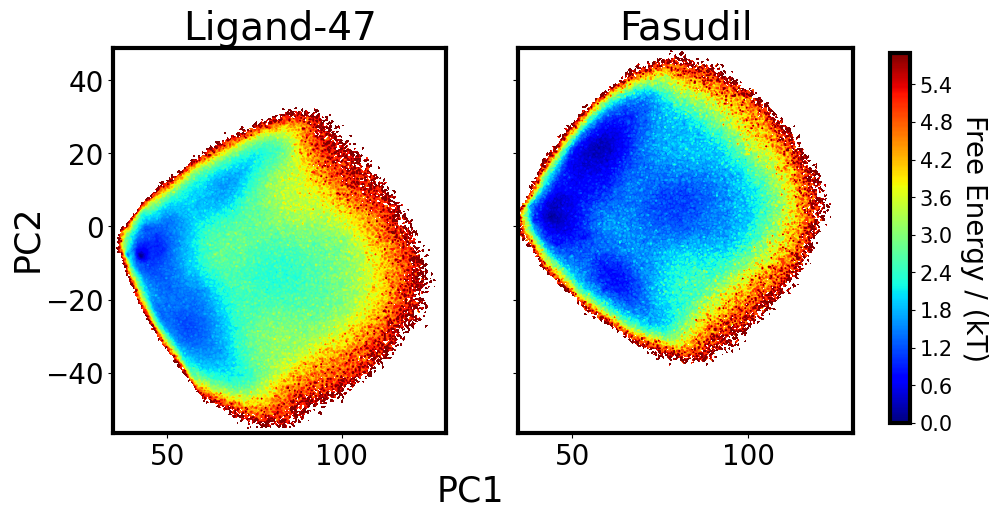

In [71]:
fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10, 5))

xlabel = 'PC1'
ylabel = 'PC2'
a = fes2d(pca_lig_47_[:,0], pca_lig_47_[:,1], ax[0], cbar = False, ) 
fes2d(pca_fasudil_[:,0], pca_fasudil_[:,1], ax[1], cbar = False) 
cbar_ax = fig.add_axes([.92, 0.13, 0.02, 0.74])#[left, bottom, width, height]
cbar = fig.colorbar(a, cax = cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Free Energy / (kT)', labelpad=25, fontsize=20, rotation= 270)
ax[0].set_title('Ligand-47', size = 28)
ax[1].set_title('Fasudil', size = 28)
plt.subplots_adjust(wspace=0.1)
fig.supylabel(ylabel,x = .04,fontsize = 25)
fig.supxlabel(xlabel,y = -0.04,fontsize = 25)


Text(0.5, -0.04, 'PC1')

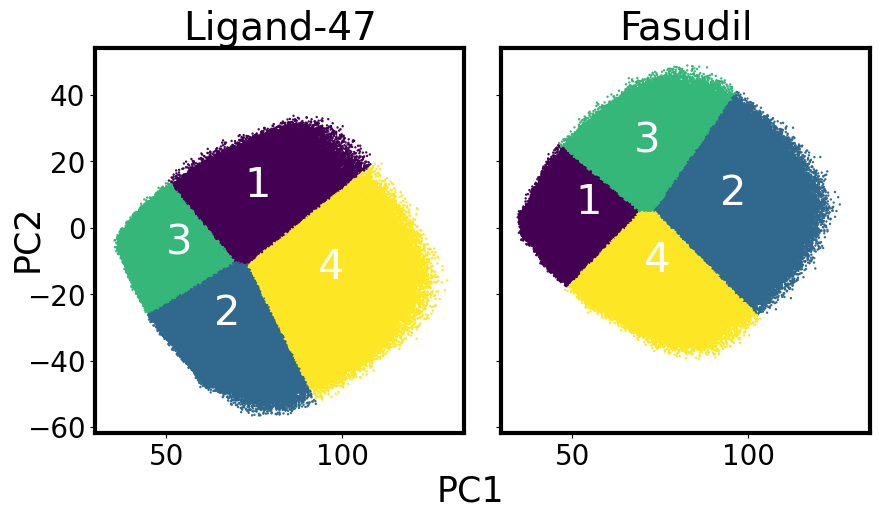

In [72]:
fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10, 5))

xlabel = 'PC1'
ylabel = 'PC2'

ax[0].scatter(*pca_lig_47_[:,:2].T, c = dtraj_lig_47, s=.5)
for j,i in enumerate(clustercenters_lig_47):
    ax[0].annotate(f"{j+1}", [i[k] for k in range(2)], color="white", size="30")
    
ax[1].scatter(*pca_fasudil_[:,:2].T, c = dtraj_fasudil, s=.5)
for j,i in enumerate(clustercenters_fasudil):
    ax[1].annotate(f"{j+1}", [i[k] for k in range(2)], color="white", size="30")
ax[0].tick_params(axis='both', labelsize=20)    
ax[0].set_title('Ligand-47', size = 28)
ax[1].tick_params(axis='both', labelsize=20)
ax[1].set_title('Fasudil', size = 28)
plt.subplots_adjust(wspace=0.1)   
fig.supylabel(ylabel,x = .04,fontsize = 25)
fig.supxlabel(xlabel,y = -0.04,fontsize = 25)

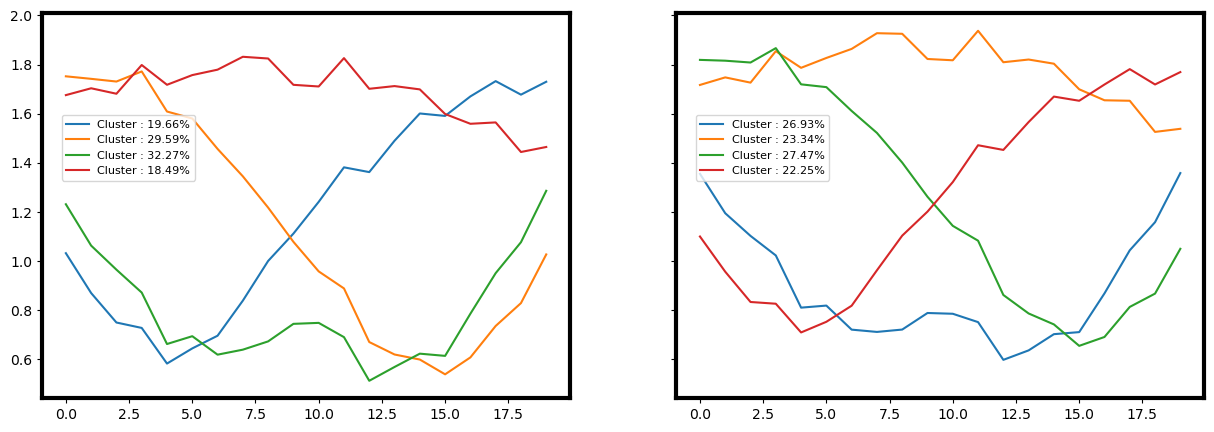

In [73]:
#xlabel = 'PC1'
ylabel = 'Number of Frames'

fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15, 5))


for i in frames_cl_lig_47:
    ax[0].plot(dmat_lig_47[i].mean(0), label = f"Cluster : {100*len(i)/len(dmat_lig_47):.2f}%")
    ax[0].legend(ncol = 1, prop={'size': 8}, bbox_to_anchor=(0.3, 0.75, 0., 0.))
    #plt.yticks(fontsize = 14)
    #plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'), rotation=90, fontsize = 14)
    #plt.xlabel('Residue', fontsize = 20)
    #plt.ylabel('Average Distance\nfor Each Cluster', fontsize = 20)

for i in frames_cl_fasudil:
    ax[1].plot(dmat_fasudil[i].mean(0), label = f"Cluster : {100*len(i)/len(dmat_fasudil):.2f}%")
    ax[1].legend(ncol = 1, prop={'size': 8}, bbox_to_anchor=(0.3, 0.75, 0., 0.))
    #plt.yticks(fontsize = 14)
    #plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'), rotation=90, fontsize = 14)
    #plt.xlabel('Residue', fontsize = 20)
    #plt.ylabel('Average Distance\nfor Each Cluster', fontsize = 20)

In [ ]:
state_mapping = {0:3, 1:2, 2:0, 3:1}
mapper = lambda x:state_mapping[x]
new_dtraj = list(map(mapper, dtraj))

In [77]:
order_lig_47 = [0, 1, 2, 3]
frames_cl_lig_47_re = list( np.array(frames_cl_lig_47, dtype=object)[order_lig_47] )

order_fasudil = [3, 2, 0, 1]
frames_cl_fasudil_re = list( np.array(frames_cl_fasudil, dtype=object)[order_fasudil] )

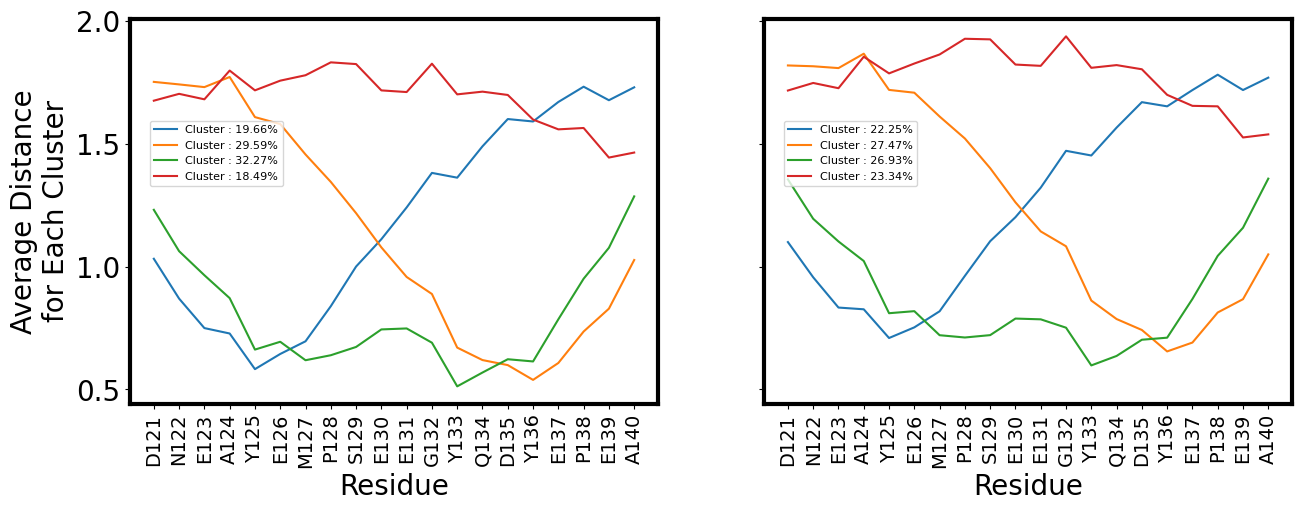

In [95]:
#xlabel = 'PC1'
ylabel = 'Number of Frames'

fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15, 5))


for i in frames_cl_lig_47_re:
    ax[0].plot(dmat_lig_47[i].mean(0), label = f"Cluster : {100*len(i)/len(dmat_lig_47):.2f}%")
    ax[0].legend(ncol = 1, prop={'size': 8}, bbox_to_anchor=(0.3, 0.75, 0., 0.))
    ax[0].tick_params(axis='both', labelsize=20)
    ax[0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'), rotation=90, fontsize = 14)
    ax[0].set_xlabel('Residue', fontsize = 20)
    ax[0].set_ylabel('Average Distance\nfor Each Cluster', fontsize = 20)

for i in frames_cl_fasudil_re:
    ax[1].plot(dmat_fasudil[i].mean(0), label = f"Cluster : {100*len(i)/len(dmat_fasudil):.2f}%")
    ax[1].legend(ncol = 1, prop={'size': 8}, bbox_to_anchor=(0.3, 0.75, 0., 0.))
    #plt.yticks(fontsize = 14)
    ax[1].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'), rotation=90, fontsize = 14)
    ax[1].set_xlabel('Residue', fontsize = 20)
    #plt.ylabel('Average Distance\nfor Each Cluster', fontsize = 20)

Text(0.06, 0.5, 'Number of Frames')

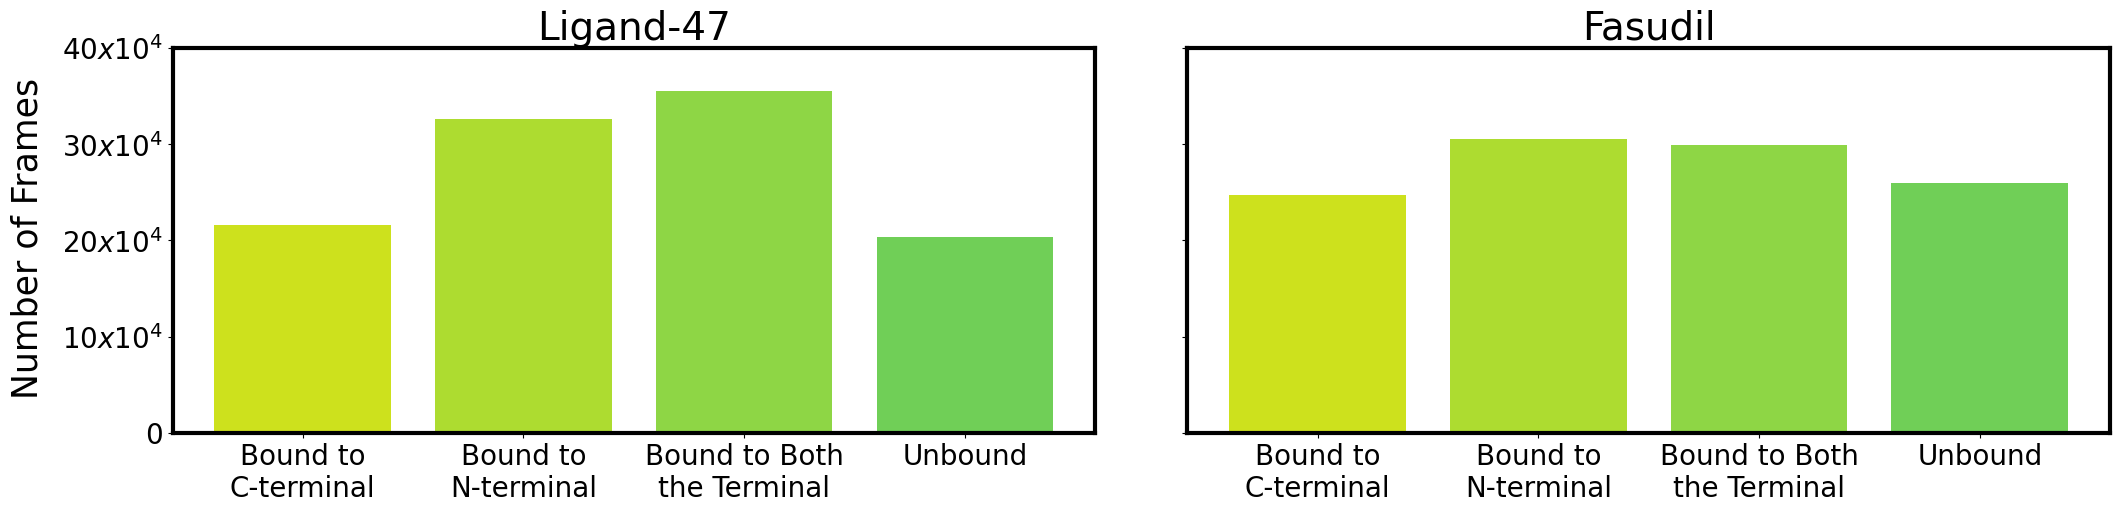

In [99]:
#xlabel = 'PC1'
ylabel = 'Number of Frames'

fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(25, 5))

cluster_size_lig_47 = []
for i in frames_cl_lig_47_re:
    cluster_size_lig_47.append(i.size)
    
langs = ['Bound to\nC-terminal', 'Bound to\nN-terminal', 'Bound to Both\nthe Terminal', 'Unbound']#, 'C_5']#, 'C_6', 'C_7', 'C_8']
ax[0].bar(langs, cluster_size_lig_47, color = clist)

cluster_size_fasudil = []
for j in frames_cl_fasudil_re:
    cluster_size_fasudil.append(j.size)
    
langs = ['Bound to\nC-terminal', 'Bound to\nN-terminal', 'Bound to Both\nthe Terminals', 'Unbound']#, 'C_5']#, 'C_6', 'C_7', 'C_8']
ax[1].bar(langs, cluster_size_fasudil, color = clist)

ax[0].tick_params(axis='both', labelsize=20)    
ax[0].set_title('Ligand-47', size = 28)
ax[0].set_yticks(range(0,500000,100000), ('0', '$10x10^4$', '$20x10^4$', '$30x10^4$', '$40x10^4$'))
ax[1].tick_params(axis='both', labelsize=20)
ax[1].set_title('Fasudil', size = 28)
plt.subplots_adjust(wspace=0.1)   
fig.supylabel(ylabel,x = .06,fontsize = 25)
#fig.supxlabel(xlabel,y = -0.04,fontsize = 25)

In [80]:
msm_lig_47 = pyemma.msm.estimate_markov_model(dtraj_lig_47, lag = 10, reversible=False)
msm_fasudil = pyemma.msm.estimate_markov_model(dtraj_fasudil, lag = 10, reversible=False)

In [102]:
frames_cl_fasudil

[array([     50,      61,      62, ..., 1110857, 1110864, 1110865]),
 array([      0,       1,       2, ..., 1110886, 1110887, 1110888]),
 array([     83,      84,      85, ..., 1110870, 1110871, 1110872]),
 array([      6,      10,      13, ..., 1110879, 1110880, 1110881])]

Text(0.5, -0.01, '$State_{j}$')

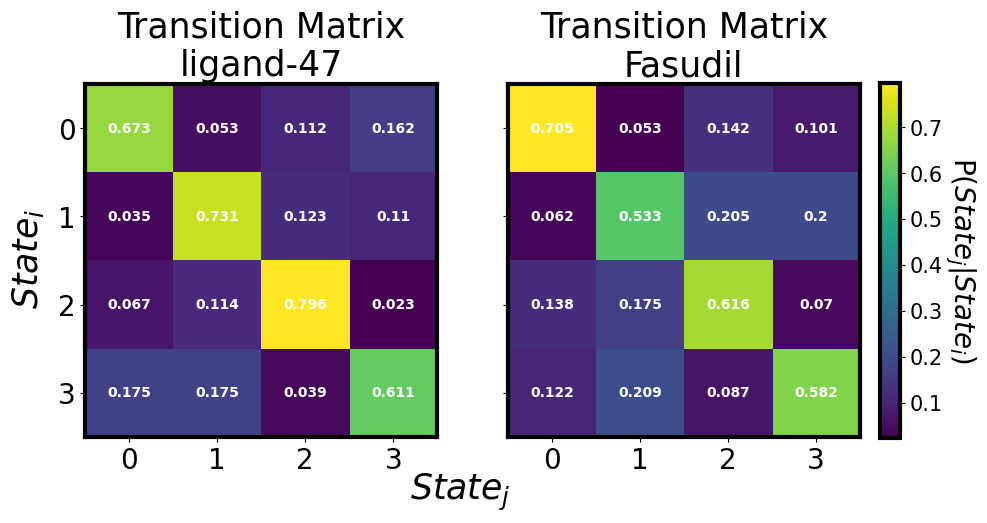

In [104]:
#transition matrix errors
xlabel = r"$State_{j}$"
ylabel = r"$State_{i}$"

fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10, 5))


a = plot_mat_error(msm_lig_47.transition_matrix,0,"Transition Matrix\nligand-47","%",10,"white","viridis",np.arange(4))

plot_mat_error(msm_fasudil.transition_matrix,1,"Transition Matrix\nFasudil","%",10,"white","viridis",np.arange(4))
#ax[0].set_xticks([0,1,2,3],('Bound to\nN-terminal','Bound to\nC-terminal','Bound to Both\nthe Terminals', 'Unbound'), rotation=90, fontsize = 14)
#ax[1].set_xticks([0,1,2,3],('Bound to Both\nthe Terminals','Unbound','Bound to\nC-terminal', 'Bound to\nN-terminal'), rotation=90, fontsize = 14)

cbar_ax = fig.add_axes([.92, 0.14, 0.02, 0.71])#[left, bottom, width, height]
cbar = fig.colorbar(a, cax = cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"P($State_{j}$|$State_{i}$)", labelpad=25, fontsize=20, rotation= 270)

fig.supylabel(ylabel,x = 0.05,fontsize = 25)
fig.supxlabel(xlabel,y = -0.01,fontsize = 25)

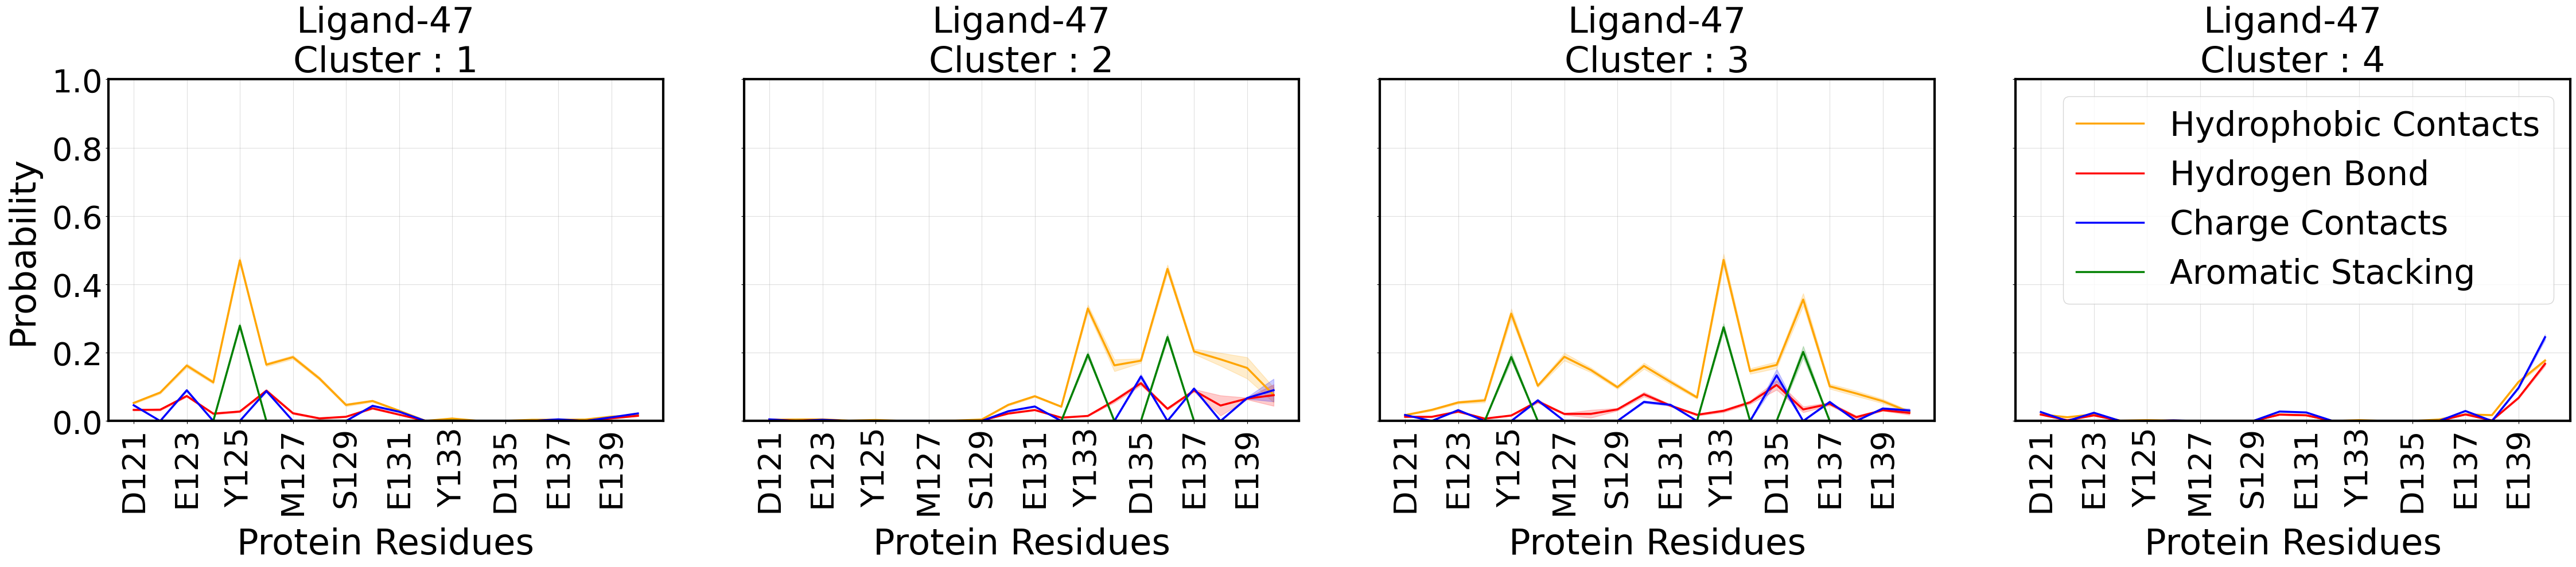

In [105]:
Hbond= np.load("intermol_Hbond_pca_combined_lig.npy" )
charge_= np.load("intermol_charge_pca_combined_lig.npy")
aro_ = np.load("intermol_aro_pca_combined_lig.npy")
hydro = np.load("intermol_hydro_pca_combined_lig.npy")

fig, ax = plt.subplots(1, 4, figsize=(45, 10), sharex=True, sharey=True)
#res = np.array([str(trj[0].topology.residue(i)) for i in range(20)])
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')

for i in range(4):
    p = np.unravel_index(i,(4))
    
    ax[p].plot(hydro[i].T[0], hydro[i].T[1], linewidth=2.5, label='Hydrophobic Contacts', color='orange')
    ax[p].fill_between(hydro[i].T[0], hydro[i].T[1]-hydro[i].T[2],
                          hydro[i].T[1]+hydro[i].T[2], alpha=0.2,color='orange')
    
    ax[p].plot(Hbond[i].T[0], Hbond[i].T[1], linewidth=2.5,label='Hydrogen Bond', color='red')
    ax[p].fill_between(Hbond[i].T[0], Hbond[i].T[1]-Hbond[i].T[2],
                          Hbond[i].T[1]+Hbond[i].T[2], alpha=0.2,color='r')
    
    ax[p].plot(charge_[i].T[0], charge_[i].T[1], linewidth=2.5,label='Charge Contacts',c='blue')
    ax[p].fill_between(charge_[i].T[0], charge_[i].T[1]-charge_[i].T[2],
                          charge_[i].T[1]+charge_[i].T[2], alpha=0.2,color='blue')
    
    ax[p].plot(aro_[i].T[0], aro_[i].T[1], linewidth=2.5, color='green', label='Aromatic Stacking')
    ax[p].fill_between(aro_[i].T[0], aro_[i].T[1]-aro_[i].T[2],
                         aro_[i].T[1]+aro_[i].T[2], alpha=0.2,color='green')
    
    ax[p].set_ylim(0,1.0)
    ax[p].set_xticks(range(int(min(Hbond[i][:,0])),int(max(Hbond[i][:,0])+1),2))
    ax[p].set_xticklabels(res_)
    ax[p].tick_params(labelsize=40)
    ax[p].grid(alpha=0.4)
    plt.setp(ax[p].get_xticklabels(), rotation=90)
    
    
    if i == 3:
        ax[p].legend(loc=1,prop={'size': 42})

    a='Ligand-47\nCluster : '+str(i+1)
    ax[p].set_title(a,size=45)
    
    #text_=r'$K_{D}$'+' : '+str(round(K[2][i],2))+r'$\pm$'+str(round(K[3][i],2))
    #ax[p].text(120.3, 0.63, text_, fontsize = 26)
    
    ax[0].set_ylabel("Probability", size=45, labelpad=15)
    ax[p].set_xlabel('Protein Residues', size=45, labelpad=15)
        
plt.tight_layout()

Text(1618.4027777777778, 0.5, 'Contact Probability')

<Figure size 640x480 with 0 Axes>

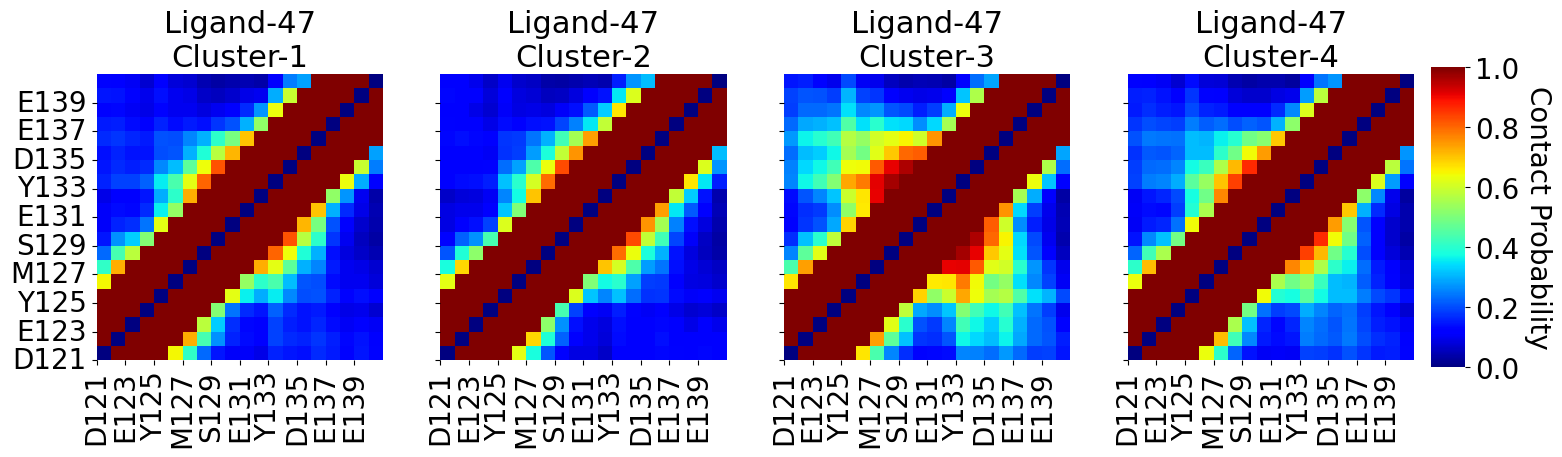

In [106]:
C = np.load("pep_contact_pca_combined_lig.npy")
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "jet",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Ligand-47\nCluster-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
#plt.savefig('Lig47_pep_contact.png', bbox_inches="tight")

Text(1618.4027777777778, 0.5, 'Contact Probability')

<Figure size 640x480 with 0 Axes>

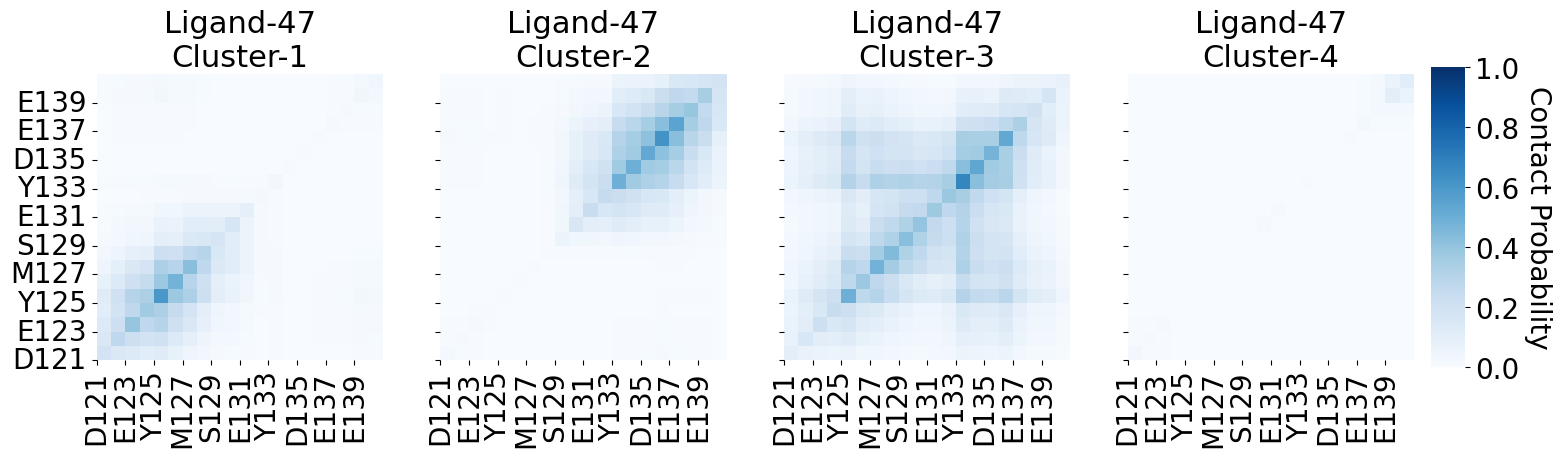

In [107]:
C_ = np.load("dual_contact_pca_combined_lig.npy")
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C_[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "Blues",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Ligand-47\nCluster-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
#plt.savefig('Lig47_dual_contact.png', bbox_inches="tight")

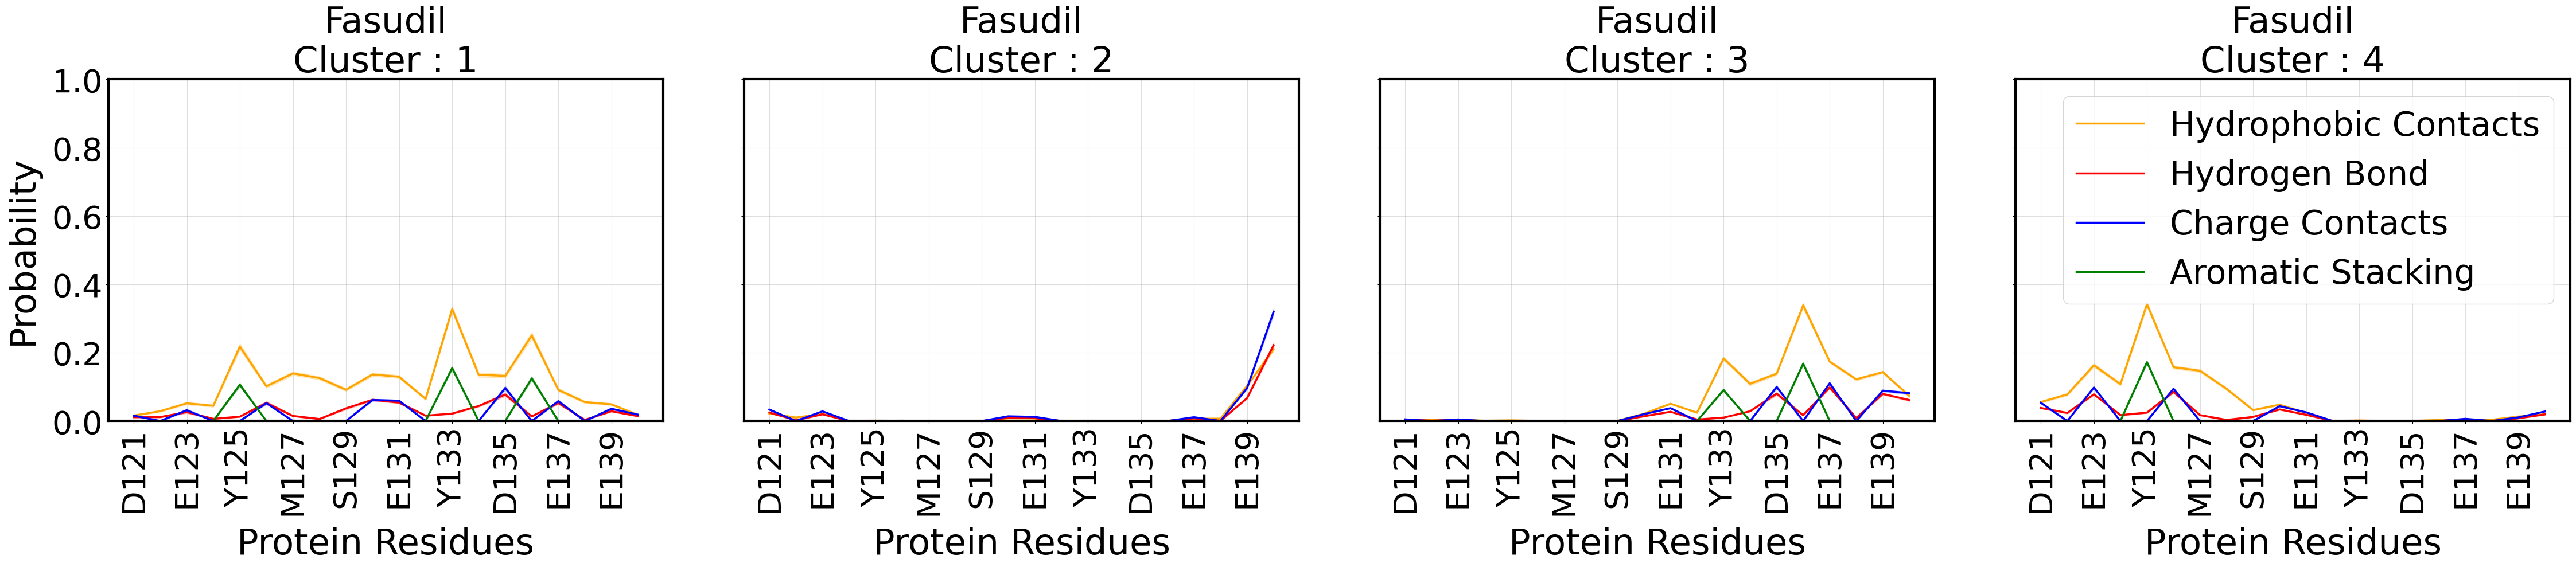

In [5]:
Hbond= np.load("/data/asn/tica/fasudil/combined/intermol_Hbond_pca_combined_fas.npy" )
charge_= np.load("/data/asn/tica/fasudil/combined/intermol_charge_pca_combined_fas.npy")
aro_ = np.load("/data/asn/tica/fasudil/combined/intermol_aro_pca_combined_fas.npy")
hydro = np.load("/data/asn/tica/fasudil/combined/intermol_hydro_pca_combined_fas.npy")

fig, ax = plt.subplots(1, 4, figsize=(45, 10), sharex=True, sharey=True)
#res = np.array([str(trj[0].topology.residue(i)) for i in range(20)])
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')

for i in range(4):
    p = np.unravel_index(i,(4))
    
    ax[p].plot(hydro[i].T[0], hydro[i].T[1], linewidth=2.5, label='Hydrophobic Contacts', color='orange')
    ax[p].fill_between(hydro[i].T[0], hydro[i].T[1]-hydro[i].T[2],
                          hydro[i].T[1]+hydro[i].T[2], alpha=0.2,color='orange')
    
    ax[p].plot(Hbond[i].T[0], Hbond[i].T[1], linewidth=2.5,label='Hydrogen Bond', color='red')
    ax[p].fill_between(Hbond[i].T[0], Hbond[i].T[1]-Hbond[i].T[2],
                          Hbond[i].T[1]+Hbond[i].T[2], alpha=0.2,color='r')
    
    ax[p].plot(charge_[i].T[0], charge_[i].T[1], linewidth=2.5,label='Charge Contacts',c='blue')
    ax[p].fill_between(charge_[i].T[0], charge_[i].T[1]-charge_[i].T[2],
                          charge_[i].T[1]+charge_[i].T[2], alpha=0.2,color='blue')
    
    ax[p].plot(aro_[i].T[0], aro_[i].T[1], linewidth=2.5, color='green', label='Aromatic Stacking')
    ax[p].fill_between(aro_[i].T[0], aro_[i].T[1]-aro_[i].T[2],
                         aro_[i].T[1]+aro_[i].T[2], alpha=0.2,color='green')
    
    ax[p].set_ylim(0,1.0)
    ax[p].set_xticks(range(int(min(Hbond[i][:,0])),int(max(Hbond[i][:,0])+1),2))
    ax[p].set_xticklabels(res_)
    ax[p].tick_params(labelsize=40)
    ax[p].grid(alpha=0.4)
    plt.setp(ax[p].get_xticklabels(), rotation=90)
    
    
    if i == 3:
        ax[p].legend(loc=1,prop={'size': 42})

    a='Fasudil\nCluster : '+str(i+1)
    ax[p].set_title(a,size=45)
    
    #text_=r'$K_{D}$'+' : '+str(round(K[2][i],2))+r'$\pm$'+str(round(K[3][i],2))
    #ax[p].text(120.3, 0.63, text_, fontsize = 26)
    
    ax[0].set_ylabel("Probability", size=45, labelpad=15)
    ax[p].set_xlabel('Protein Residues', size=45, labelpad=15)
        
plt.tight_layout()

Text(1618.4027777777778, 0.5, 'Contact Probability')

<Figure size 640x480 with 0 Axes>

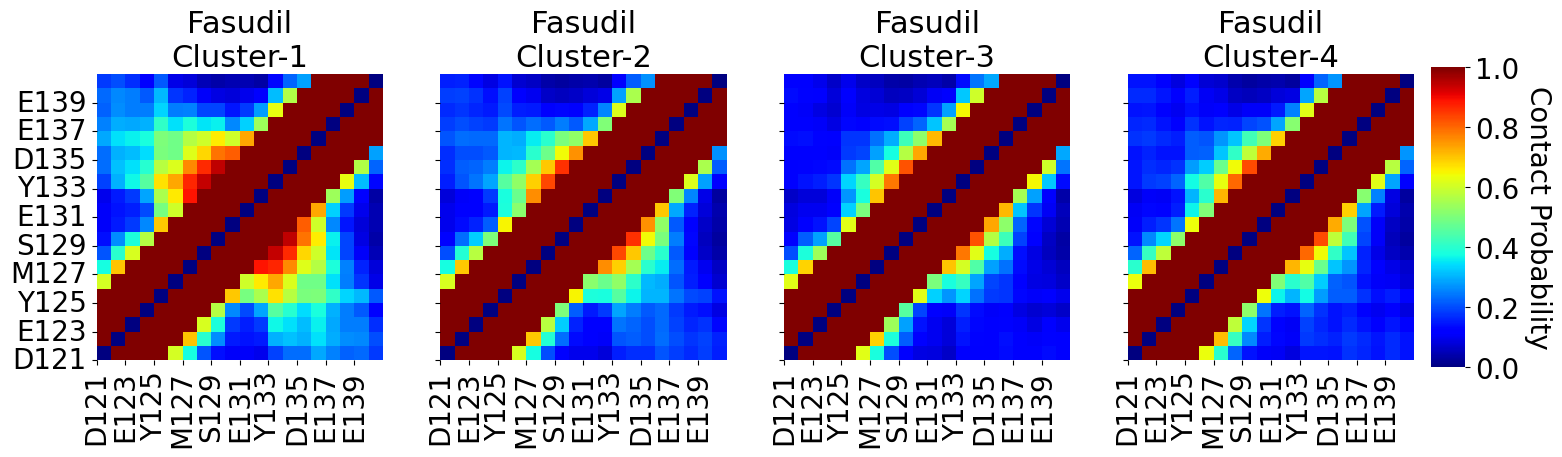

In [6]:
C = np.load("/data/asn/tica/fasudil/combined/pep_contact_pca_combined_fas.npy")
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "jet",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Fasudil\nCluster-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
#plt.savefig('Lig47_pep_contact.png', bbox_inches="tight")

Text(1618.4027777777778, 0.5, 'Contact Probability')

<Figure size 640x480 with 0 Axes>

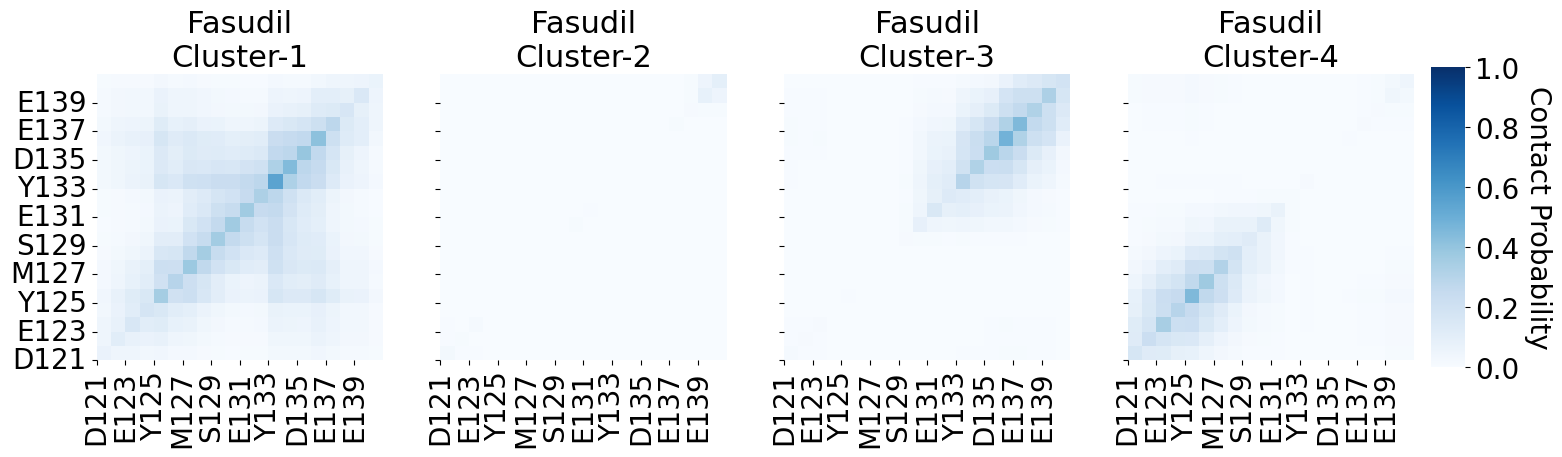

In [7]:
C_ = np.load("/data/asn/tica/fasudil/combined/dual_contact_pca_combined_fas.npy")
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C_[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "Blues",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Fasudil\nCluster-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
#plt.savefig('Lig47_dual_contact.png', bbox_inches="tight")